# Assignment 2: recommender System

## Code from the lecture

In [1]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../../DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../../DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../../DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [2]:
#generate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

In [3]:
epsilon=0.0000001 
def CosineDist(a,b):
    return a.dot(b)/(np.linalg.norm(a)*np.linalg.norm(b)+epsilon) #added epsilon for numerical stability: avoiding div by zero -> NaN
def EucledianDist(a,b):
    return np.linalg.norm(a-b) #added epsilon for numerical stability: avoiding div by zero -> NaN

In [4]:
%%time
#again, implementation not efficient: better use lamda opperators 
D_cos=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D_cos[i,j]=CosineDist(R[:,i],R[:,j])
            
D_euc=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D_euc[i,j]=EucledianDist(R[:,i],R[:,j])            
                       

Wall time: 2min 57s


In [5]:
def getTopN(movie_id, D, N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title, D):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title),D))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

In [6]:
# With cosinus distance
CII("Star",D_cos)

recommending movies for: 'Star Wars (1977)'


180          Return of the Jedi (1983)
173     Raiders of the Lost Ark (1981)
171    Empire Strikes Back, The (1980)
0                     Toy Story (1995)
126              Godfather, The (1972)
Name: title, dtype: object

In [7]:
# With eucledian distance
CII("Star",D_euc)

recommending movies for: 'Star Wars (1977)'


989              Anna Karenina (1997)
1061    Four Days in September (1997)
1126          Truman Show, The (1998)
937        Smile Like Yours, A (1997)
1242               Night Flier (1997)
Name: title, dtype: object

Text(0.5, 1.05, 'With eucledian distance')

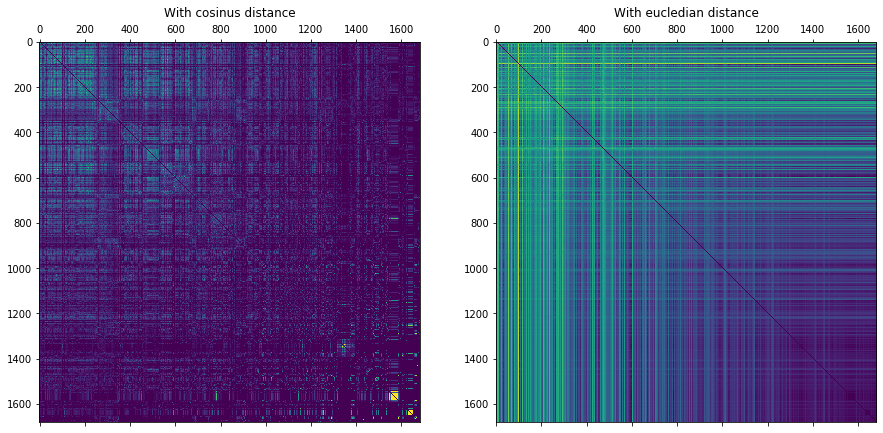

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

ax1.matshow(D_cos)
ax1.set_title('With cosinus distance')
ax2.matshow(D_euc)
ax2.set_title('With eucledian distance')

In [10]:
test_res_cos=test_Score(D_cos,R)
test_res_euc=test_Score(D_euc,R)

Text(0.5, 1.0, 'With eucledian distance')

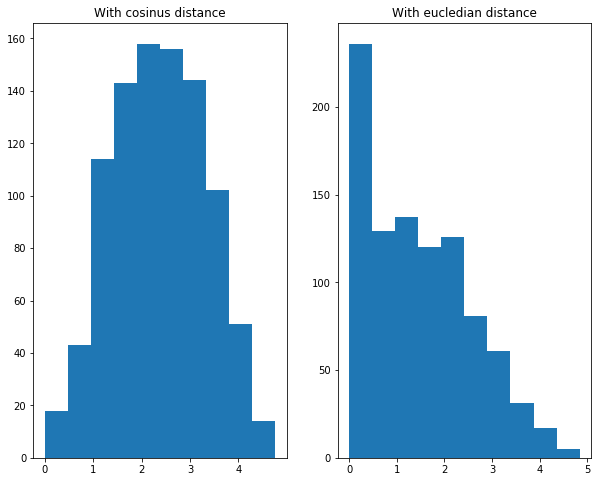

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))

ax1.hist(test_res_cos)
ax1.set_title('With cosinus distance')
ax2.hist(test_res_euc)
ax2.set_title('With eucledian distance')

In [13]:
print('mean value test results with cosinus:  ', np.mean(test_res_cos))
print('mean value test results with eucledian:', np.mean(test_res_euc))

mean value test results with cosinus:   2.3701802757158004
mean value test results with eucledian: 1.4630328738069989


## 4.2 Baseline Results
Implement and compare results of two very simple baseline methods 
* random recommendations: randomly recommend 5 movies (HINT user np.random sub-library to generate random movie IDs)
* always recommending the top 5 movies: HINT: need to find the IDs of the top 5 movies over all users first

In [14]:
from sklearn.model_selection import train_test_split
R_train, R_test = train_test_split(R, test_size=0.1)

def getRandomRec(D, n=5):
    M_random = np.random.randint(D.shape[1], size=n)
    return M_random

def getTopRec(D):
    ranking = np.sum(D,axis=0)
    indices = np.argpartition(ranking, -5)[-5:]
    return indices    

def Score_byID_random(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getRandomRec(D)
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)

def Score_byID_top5(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopRec(D)
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)

def test_Score_new(D_train, R_test, random=True):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        if random == True:  
            for e in userTop:
                res_id, res_title, res_score, av_score = Score_byID_random(e,D_train, R_test[i])
                userScore+=av_score
            userScores.append(userScore/(5))
        else:
            for e in userTop:
                res_id, res_title, res_score, av_score = Score_byID_top5(e,D_train, R_test[i])
                userScore+=av_score
            userScores.append(userScore/(5))
            
    return userScores

In [15]:
top5_random = getRandomRec(D_cos,5)
print(top5_random)
top5_static = getTopRec(D_cos)
print(top5_static)

[  27  538  607  628 1044]
[ 78  55 203 171 173]


### Comparison of the results

In [16]:
test_res_random = test_Score_new(D_cos,R_test,random = True)
test_res_top5 = test_Score_new(D_cos,R_test,random = False)

In [17]:
print('mean value test results with random movies:', np.mean(test_res_random))
print('mean value test results with top 5 movies: ', np.mean(test_res_top5))

mean value test results with random movies: 0.15831578947368416
mean value test results with top 5 movies:  1.5368421052631582


## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $D$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct and evaluate $D'$


In [20]:
U,S,V = np.linalg.svd(D_cos)

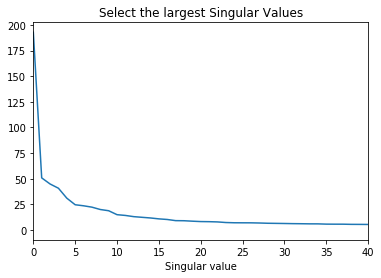

In [21]:
fig,ax1 = plt.subplots()
ax1.set_xlim([0,40])
ax1.set_xlabel("Singular number")
ax1.set_xlabel("Singular value")
ax1.set_title('Select the largest Singular Values')
ax1.plot(S)

In [22]:
cut = 30
D_new = np.dot(U[:,:cut]*S[:cut],V[:cut,:])

### Tests with the new D

In [25]:
D_old = D_cos
print("D old:")
CII("Star",D_old)

D old:
recommending movies for: 'Star Wars (1977)'


180          Return of the Jedi (1983)
173     Raiders of the Lost Ark (1981)
171    Empire Strikes Back, The (1980)
0                     Toy Story (1995)
126              Godfather, The (1972)
Name: title, dtype: object

In [26]:
print("D new:")
CII("Star",D_new)

D new:
recommending movies for: 'Star Wars (1977)'


49                    Star Wars (1977)
173     Raiders of the Lost Ark (1981)
180          Return of the Jedi (1983)
171    Empire Strikes Back, The (1980)
203          Back to the Future (1985)
Name: title, dtype: object

Text(0.5, 1.0, 'With D new')

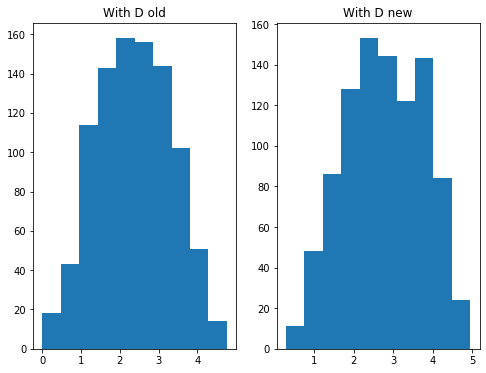

In [46]:
test_res_D_old=test_Score(D_old,R)
test_res_D_new=test_Score(D_new,R)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,6))

ax1.hist(test_res_D_old)
ax1.set_title('With D old')
ax2.hist(test_res_D_new)
ax2.set_title('With D new')

In [28]:
print('mean value test results with D old:', np.mean(test_res_D_old))
print('mean value test results with D new:', np.mean(test_res_D_new))

mean value test results with D old: 2.3701802757158004
mean value test results with D new: 2.770349946977731
